# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans
from datetime import datetime

In [3]:
eshop = pd.read_csv('eshop.csv')

In [4]:
display(eshop.head(90))
display(eshop.tail())

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.00,Czech Republic
1,38,6/27/2007,38.40,Czech Republic
2,47,7/2/2007,53.50,Slovakia
3,61,7/14/2007,7.00,Czech Republic
4,78,7/21/2007,55.50,Czech Republic
...,...,...,...,...
85,495,3/27/2008,30.32,Czech Republic
86,459,3/28/2008,69.80,Czech Republic
87,464,4/6/2008,3.25,United Kingdom
88,512,4/7/2008,7.90,Czech Republic


,Customer ID,Date,Subtotal,Country
22403,15356,12/18/2015,31.87,Czech Republic
22404,15357,12/18/2015,6.10,Czech Republic
22405,15358,12/18/2015,153.23,Czech Republic
22406,15359,12/19/2015,19.15,Czech Republic
22407,15360,12/19/2015,139.10,Czech Republic


### Vytvořte rfm data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
-> Musím získat sloupce:
#### ID, Recency, Frequency, Monetary
pro každého zákazníka podle customer ID hledám všechny jeho záznamy, ty počítám do jednoho řádku 
- **recency** = nejvyšší datum s daným ID
- **frequency** = součet výskytů daného ID
- **monetary** = součet subtotals daného ID

In [5]:
customers = []
class Customer:
    def __init__(self, id_num, recency, monetary):
        self.id = id_num
        self.recency = recency
        self.monetary = monetary
        self.frequency = 1

In [6]:
def days_since(str_date):
    most_recent_date = datetime.strptime(eshop.iloc[-1]['Date'], '%m/%d/%Y') # mm dd YYYY
    now_date = datetime.strptime(str_date, '%m/%d/%Y')
    return (most_recent_date - now_date).days

In [7]:
def months_since(str_date):
    most_recent_date = datetime.strptime(eshop.iloc[-1]['Date'], '%m/%d/%Y') # mm dd YYYY
    now_date = datetime.strptime(str_date, '%m/%d/%Y')
    return (most_recent_date.year - now_date.year)*12 + most_recent_date.month - now_date.month

In [8]:
customers = []
for i, row in eshop.iterrows():
    a = next((customer for customer in customers if customer.id == row['Customer ID']), None)
    if a != None:
        customers[customers.index(a)].recency = days_since(row['Date'])
        customers[customers.index(a)].monetary += row['Subtotal']
        customers[customers.index(a)].frequency += 1
    else:
        customers.append(Customer(row['Customer ID'], days_since(row['Date']), row['Subtotal']))
             

In [9]:
cust_columns = ['recency', 'monetary', 'frequency']
rfm = pd.DataFrame([[getattr(i,j) for j in cust_columns] for i in customers], columns = cust_columns)

In [10]:
rfm.head(100)
rfm.shape

(12829, 3)

### Použití algoritmu k-means
Graf vykresluji ve tvaru x = recency, y = monetary, z = frequency.

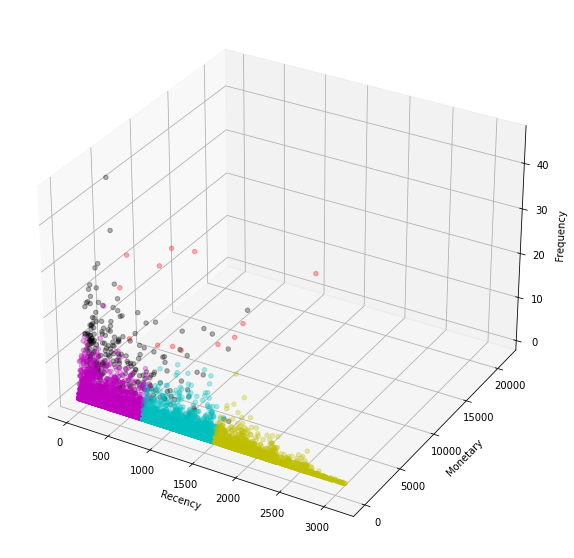

In [11]:
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(rfm)
LABEL_COLOR_MAP = {0 : 'c', 1 : 'm', 2 : 'y', 3 : 'k', 4 : 'r', 5 : 'g', 6 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
km = plt.figure(figsize=(15, 10)).add_subplot(111, projection='3d')
km.scatter(rfm.iloc[:,0],rfm.iloc[:,1],rfm.iloc[:,2], color = label_color, alpha = 0.3)
km.set_xlabel("Recency")
km.set_ylabel("Monetary")
km.set_zlabel("Frequency")
plt.show()

Je vidět, že recency, monetary i frequency mají všechny jiné rozmezí hodnot, což může shluky negativně ovlivnit, proto by bylo vhodné data přeškálovat, aby byly všechny ve stejném rozmezí (tedy od 0 do 1).

### Přeškálování dat
Jak se změní clustery, pokud data přeškáluji na hodnoty mezi 0 a 1?

In [23]:
def scale(df):
    # 1. maximum recency
    recency = df['recency']
    max_rec = recency.max()
    # 2. maximum monetary
    monetary = df['monetary']
    max_mon = monetary.max()
    # 3. maximum frequency
    frequency = df['frequency']
    max_fre = frequency.max()
    
    new_dataframe = pd.DataFrame()
    for index, row in df.iterrows():
        a = row["recency"]/max_rec
        tmp = {"recency": row["recency"]/max_rec, "monetary": row["monetary"]/max_mon, "frequency": row["frequency"]/max_fre}
        new_dataframe = new_dataframe.append(tmp, ignore_index = True)
    return new_dataframe
    

In [13]:
rfm_scaled = scale(rfm)

In [14]:
display(rfm_scaled)
rfm_scaled.shape

,frequency,monetary,recency
0,0.022222,0.004020,1.000000
1,0.022222,0.001795,0.998066
2,0.022222,0.002501,0.996455
3,0.022222,0.000327,0.992588
4,0.022222,0.002594,0.990332
...,...,...,...
12824,0.022222,0.001490,0.000322
12825,0.022222,0.000285,0.000322
12826,0.022222,0.007163,0.000322
12827,0.022222,0.000895,0.000000


(12829, 3)

Graf vykreslím pro přehlednost ve formátu x = recency, y = frequency, z = monetary.

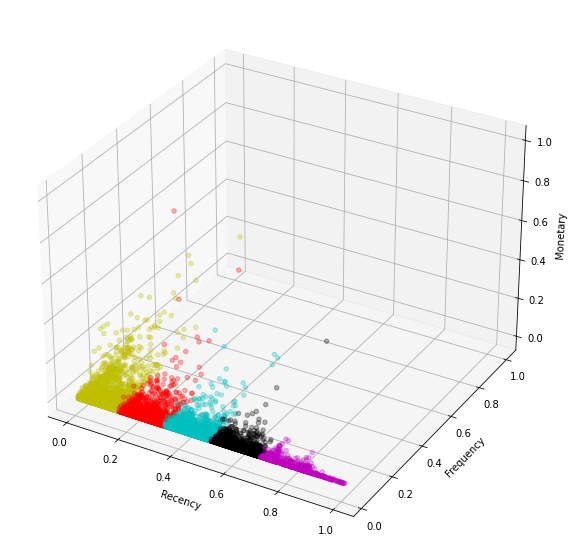

In [15]:
kmeans2 = KMeans(n_clusters = 5, random_state = 0).fit(rfm_scaled)
rfm_scaled.shape
LABEL_COLOR_MAP = {0 : 'c', 1 : 'm', 2 : 'y', 3 : 'k', 4 : 'r', 5 : 'g', 6 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans2.labels_]
km2 = plt.figure(figsize=(15, 10)).add_subplot(111, projection='3d')
km2.scatter(rfm_scaled.iloc[:,2],rfm_scaled.iloc[:,0],rfm_scaled.iloc[:,1], color = label_color, alpha = 0.3)
km2.set_xlabel("Recency")
km2.set_ylabel("Frequency")
km2.set_zlabel("Monetary")
plt.show()

Jak lze vidět z obou grafů, výsledné shluky se velmi liší, myslím si tedy, že je přeškálování na místě.

### Nejlepší počet shluků - hledání minima užitkové funkce výsledku
Neškálované data:

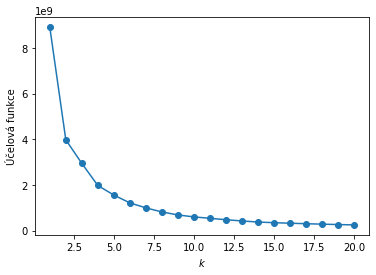

In [16]:
x = np.zeros(20)
y = np.zeros(20)
for k in range(x.shape[0]):
    kmeans = KMeans(n_clusters=k+1, random_state = 1)
    kmeans.fit(rfm)
    y[k] = kmeans.inertia_
    x[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(x, y, 'o-')
plt.show()

Škálované data:

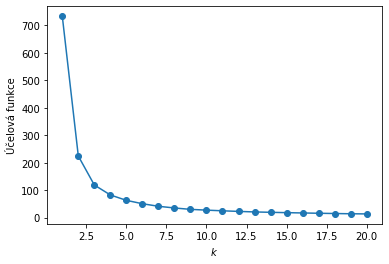

In [17]:
x2 = np.zeros(20)
y2 = np.zeros(20)
for k in range(x2.shape[0]):
    kmeans2 = KMeans(n_clusters=k+1, random_state = 1)
    kmeans2.fit(rfm_scaled)
    y2[k] = kmeans2.inertia_
    x2[k] = k+1

plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(x2, y2, 'o-')
plt.show()

Zde je vidět, jak se mění účelová funkce pro nepřeškálovaná data a pro přeškálovaná data. Dále budu již pracovat jen s přeškálovanými daty.
Za loket podle grafu zvolím k = 7, při vyšší hodnotě se začínají dělit spíše jen shluky představující nezajímavé zákazníky (vysoká recency, nízká monetary a nízká frequency). Účelová fuknce také po tomto bodě klesá již jen pomalu.

### Výsledné shluky a jejich interpretace

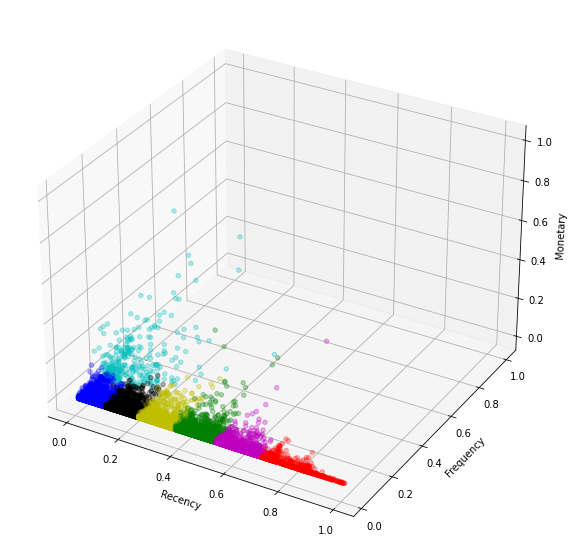

In [18]:
kmeans = KMeans(n_clusters = 7, random_state = 0).fit(rfm_scaled)
LABEL_COLOR_MAP = {0 : 'c', 1 : 'm', 2 : 'y', 3 : 'k', 4 : 'r', 5 : 'g', 6 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]
km = plt.figure(figsize=(15, 10)).add_subplot(111, projection='3d')
km.scatter(rfm_scaled.iloc[:,2],rfm_scaled.iloc[:,0],rfm_scaled.iloc[:,1], color = label_color, alpha = 0.3)
km.set_xlabel("Recency")
km.set_ylabel("Frequency")
km.set_zlabel("Monetary")
plt.show()

Zajímaví zákazníci - vysoká monetary a frequency, nízká recency - se nacházejí ve shluku obarveném světle modrou barvou. "Nejhorší" zákazníci jsou obarveni červeně.

### Modifikované RMF
- **Recency** - **maximum** počtu měsíců od posledního nákupu (months_since) a čísla 1
- **Frequency** - maximum počtu nákupů daného zákazníka **v posledních 12 měsících** a čísla 1
- **Monetary** - **nejvyšší hodnota** nákupu daného zákazníka

In [22]:
customers_mod = []
for i, row in eshop.iterrows():
    a = next((customer for customer in customers_mod if customer.id == row['Customer ID']), None)
    if a != None:
        # jelikoz jdou zaznamy v tabulce casove po sobe, vzdy se prideli novejsi nakup
        customers_mod[customers_mod.index(a)].recency = max(months_since(row['Date']), 1)
        customers_mod[customers_mod.index(a)].monetary = max(row['Subtotal'], customers_mod[customers_mod.index(a)].monetary, 1)
        if months_since(row['Date']) <= 12:
            customers_mod[customers_mod.index(a)].frequency += 1
    else:
        customers_mod.append(Customer(row['Customer ID'], months_since(row['Date']), row['Subtotal']))
        # tim padem to vzdy bude alespon 1
             

Pro lepší vzhled grafu jsem zvolila osy tak, že x = recency, y = frequency a z = monetary. Použila jsem opět 7 clusterů po vzoru předchozích výsledků.

In [20]:
cust_columns2 = ['recency', 'frequency', 'monetary']
rfm2 = pd.DataFrame([[getattr(i,j) for j in cust_columns2] for i in customers_mod], columns = cust_columns2)
rfm2_scaled = scale(rfm2)

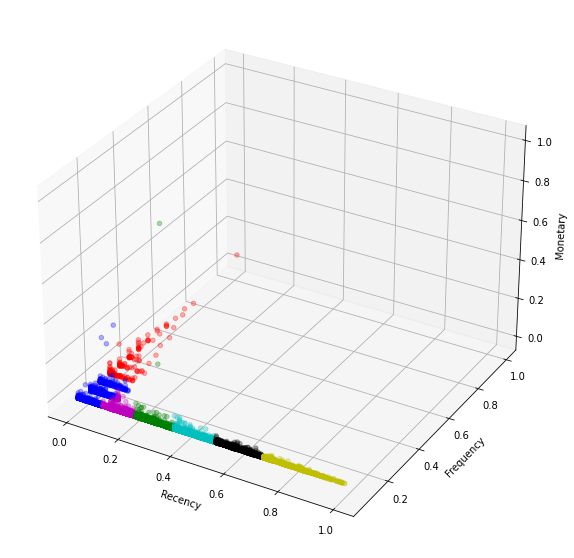

In [21]:
kmeans3 = KMeans(n_clusters = 7, random_state = 0).fit(rfm2_scaled)
LABEL_COLOR_MAP = {0 : 'c', 1 : 'm', 2 : 'y', 3 : 'k', 4 : 'r', 5 : 'g', 6 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans3.labels_]
km3 = plt.figure(figsize=(15, 10)).add_subplot(111, projection='3d')
km3.scatter(rfm2_scaled.iloc[:,2],rfm2_scaled.iloc[:,0],rfm2_scaled.iloc[:,1], color = label_color, alpha = 0.3)
km3.set_xlabel("Recency")
km3.set_ylabel("Frequency")
km3.set_zlabel("Monetary")
plt.show()

V tomto grafu jasně vyčnívají "superzákazníci", kteří jsou obarveni červenou barvou.